## Imports

In [3]:
import numpy as np
import pandas as pd
from matplotlib import image
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Loading the Images

In [4]:
def load_images(path):
    column_names = [f'pixel{i}' for i in range(1, 28 * 28 + 1)]
    column_names.append('label')
    images_df = pd.DataFrame(columns=column_names)

    for subpath in os.listdir(path):
        images = []
        full_path = os.path.join(path, subpath)
        for img in os.listdir(full_path):
            img_data = image.imread(os.path.join(full_path, img))
            images.append(img_data.flatten())
        
        subpath_df = pd.DataFrame(images, columns=column_names[:-1])
        subpath_df['label'] = subpath
        
        # drop empty columns before concatenating
        subpath_df = subpath_df.dropna(axis=1, how='all')
        
        images_df = pd.concat([images_df, subpath_df], ignore_index=True)
    
    return images_df

train_set = load_images("Train")
test_set = load_images("Test")

X_train_og = train_set.drop(columns='label')
y_train_og = train_set['label']

X_test_og = test_set.drop(columns='label')
y_test_og = test_set['label']

X_train = np.array(X_train_og)
y_train = np.array(y_train_og)

X_test = np.array(X_test_og)
y_test = np.array(y_test_og)

# changing labels to numeric data
encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

# reshape input to (m, 28*28) instead of (m, 1, 28*28)
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

train_set.head()

/tmp/ipykernel_20489/896595247.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  images_df = pd.concat([images_df, subpath_df], ignore_index=True)
/tmp/ipykernel_20489/896595247.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  images_df = pd.concat([images_df, subpath_df], ignore_index=True)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jovi
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jovi
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jovi
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jovi
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.0,0.0,Jovi


## Activation functions with derivates

In [5]:
def relu(X, derivative=False):
    if derivative:
        return np.where(X > 0, 1, 0)
    return np.maximum(0, X)

def softmax(X):
    e_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return e_X / np.sum(e_X, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred, derivative=False):
    if derivative:
        return y_pred - y_true
    else:
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-15)) / m  # added negligible value to avoid 0 error


losses = []

## Defining a Layer

In [ ]:
class Layer:
    def __init__(self, input_size, output_size, atype):
        self.weights = np.random.randn(input_size, output_size) * 0.01  # init weights are random and small
        self.bias = np.zeros((1, output_size))  # init biases = 0
        self.atype = atype

    def forward(self, input_data):
        self.input_data = input_data
        self.predictions = np.dot(input_data, self.weights) + self.bias
        if self.atype == 'relu':
            self.apreds = relu(self.predictions)  # apply activation to induce non-linearity
        elif self.atype == 'softmax':
            self.apreds = softmax(self.predictions)  # softmax for output layer
        return self.apreds

    def backward(self, dA, alpha):
        # backpropagation implementation
        if self.atype == 'relu':
            # derivative of ReLU
            dZ = dA * relu(self.predictions, derivative=True)
        elif self.atype == 'softmax':
            dZ = dA
        
        # gradient of loss wrt w and b
        m = self.input_data.shape[0]
        dW = np.dot(self.input_data.T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        
        # update w and b
        self.weights -= alpha * dW
        self.bias -= alpha * db
        
        # return dA for the last layer
        dA_prev = np.dot(dZ, self.weights.T)
        return dA_prev

## Defining a Neural Network

In [ ]:
class NeuralNetwork:
    def __init__(self, layer_sizes, atype):
        self.layers = []
        for i in range(1, len(layer_sizes)):
            activator = 'relu' if i < len(layer_sizes) - 1 else 'softmax'  # using ReLU for hidden layers and Softmax for output
            self.layers.append(Layer(layer_sizes[i-1], layer_sizes[i], activator))

    def forward(self, X):
        self.cache = []  # storing the activations of each layer
        activation = X
        for layer in self.layers:
            activation = layer.forward(activation)
            self.cache.append(activation)
        return activation

    def backward(self, X, y_true, alpha):
        # compute loss gradient
        dA = cross_entropy_loss(y_true, self.cache[-1], derivative=True)
        
        # backpropagate through each layer in reverse
        for layer in reversed(self.layers):
            dA = layer.backward(dA, alpha)

    def train(self, X, y, epochs, alpha):
        for epoch in range(epochs):
            # forward pass
            predictions = self.forward(X)
            
            # compute the loss
            loss = cross_entropy_loss(y, predictions)
            losses.append(loss)
            # backward pass (update weights and biases)
            self.backward(X, y, alpha)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss}")
                
    def predictions(self, values):
        # final predictions for the model
        return self.forward(values)

## Running the model

Epoch 0/3001, Loss: 1.6085007859953087
Epoch 100/3001, Loss: 0.5660708219458725
Epoch 200/3001, Loss: 0.2690579077058538
Epoch 300/3001, Loss: 0.19194997631681462
Epoch 400/3001, Loss: 0.1581095538432394
Epoch 500/3001, Loss: 0.1396213880214379
Epoch 600/3001, Loss: 0.12761753718426522
Epoch 700/3001, Loss: 0.11868703588790092
Epoch 800/3001, Loss: 0.11172221893525808
Epoch 900/3001, Loss: 0.10592421973537125
Epoch 1000/3001, Loss: 0.10087678503998637
Epoch 1100/3001, Loss: 0.09637523385186506
Epoch 1200/3001, Loss: 0.09226606037478778
Epoch 1300/3001, Loss: 0.08847854939203073
Epoch 1400/3001, Loss: 0.08496117361650395
Epoch 1500/3001, Loss: 0.08168313846750785
Epoch 1600/3001, Loss: 0.07861110689935566
Epoch 1700/3001, Loss: 0.07572287115371164
Epoch 1800/3001, Loss: 0.0730115358978425
Epoch 1900/3001, Loss: 0.07045782507725407
Epoch 2000/3001, Loss: 0.06804057095061758
Epoch 2100/3001, Loss: 0.06574896618324387
Epoch 2200/3001, Loss: 0.0635981527214885
Epoch 2300/3001, Loss: 0.06158

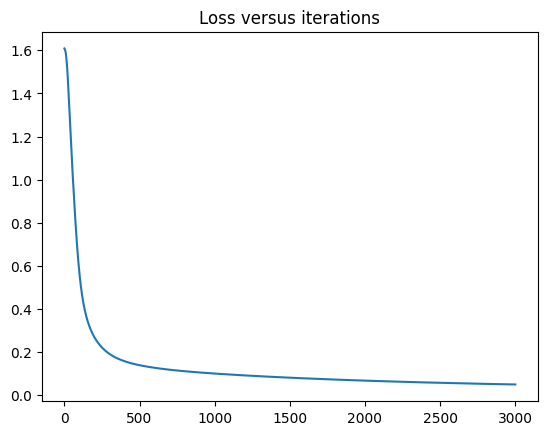

In [8]:
layer_sizes = [28*28, 70, 5]  # [input size, hidden layer size, output size]
atype = 'relu'  # ReLU for hidden layers, Softmax for output
nn = NeuralNetwork(layer_sizes, atype)
epochs = 3001
alpha = 0.1325
nn.train(X_train, y_train, epochs, alpha)

plt.plot(range(0, epochs), losses)
plt.title("Loss versus iterations")
plt.show()

## Using the above model to calculate outputs and scores

[[2.75263106e-09 1.31356973e-24 2.47364428e-03 1.08197500e-10
  9.97526353e-01]
 [2.70292006e-05 7.33166434e-22 8.91881420e-01 5.75956940e-07
  1.08090975e-01]
 [1.28535965e-06 1.37381316e-23 1.55960090e-02 3.80660737e-09
  9.84402702e-01]
 ...
 [9.94481182e-11 9.98676959e-01 4.84453530e-10 1.32304088e-03
  1.02241751e-21]
 [8.05928945e-08 7.55325876e-01 7.86491770e-08 2.44673965e-01
  1.09956904e-21]
 [4.76194055e-10 9.98291198e-01 5.25629974e-10 1.70880119e-03
  7.98740654e-21]]
(1000,) (1000,)


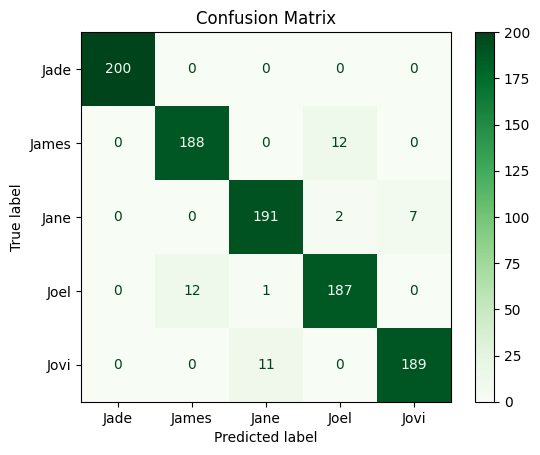

In [17]:

# final predictions to compare with y_test defined earlier
y_pred = nn.predictions(X_test)
print(y_pred)

# argmax functions to fit into confusion matrix
yhat = np.argmax(y_pred, axis=1)
y = np.argmax(y_test, axis=1)
print(y.shape, yhat.shape)

cm = confusion_matrix(y, yhat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.categories_[0])
disp.plot(cmap=plt.cm.Greens)

plt.title("Confusion Matrix")
plt.show()

## Accuracies and Scores

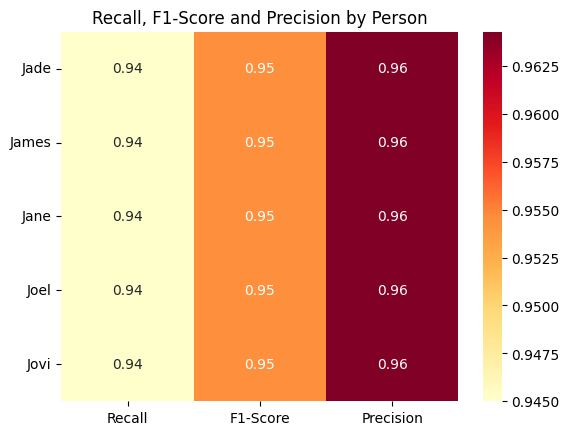

Accuracy =  0.955
F1 Score =  0.9545454545454546
Recall Score =  0.945
Precision =  0.9642857142857143


In [16]:

# storing the f1 score of the model
f1 = f1_score(y, yhat, average=None, labels=np.unique(y))
# storing the recall score of the model
recall = recall_score(y, yhat, average=None, labels=np.unique(y))
# storing the accuracy score of the model
accuracy = accuracy_score(y, yhat)
# storing the precision score of the model
precision = precision_score(y, yhat, average=None, labels=np.unique(y))

# creating a df for the heatmap
scores = pd.DataFrame({
    'Recall': recall[-1],
    'F1-Score': f1[-1],
    'Precision': precision[-1],
}, index=encoder.categories_[0])

sns.heatmap(scores, annot=True, fmt=".2f", cmap="YlOrRd", cbar=True)
plt.title("Recall, F1-Score and Precision by Person")
plt.yticks(rotation=0)
plt.show()

print("Accuracy = ",accuracy)
print("F1 Score = ", f1[-1])
print("Recall Score = ", recall[-1])
print("Precision = ", precision[-1])

## Conclusion

The Neural Network predicts fairly accurate results, classifying the vast majority of teeth to their respective owners.

This NN has 3 layers, and uses reLU for intermediate activations and Softmax for the output activation.

3001 cycles of front and back propogation allows the weights and biases to be fine tuned and provide the above >95% accuracy scores.
